# Martian Frost Detection Using CNN and Transfer Learning in HiRISE Images


<h5>This project focuses on developing classifiers to identify frost in Martian terrain images, using the HiRISE dataset. It encompasses data pre-processing, training of a Convolutional Neural Network (CNN) combined with a Multilayer Perceptron (MLP), and the application of transfer learning techniques with pre-trained models. The objective is to compare the effectiveness of a custom-built CNN+MLP model against models using transfer learning (EfficientNetB0, ResNet50, and VGG16) in classifying images into 'frost' and 'background' categories. The project evaluates the models based on precision, recall, and F1 score, and involves empirical regularization through image augmentation.</h5>

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data

In [4]:
import random
import tensorflow as tf
from PIL import Image 

def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        
        img = Image.open(img_loc_str).convert('RGB')
        
        
        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 5

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

In [6]:
tf_dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))>

# Training CNN + MLP

### To perform empirical regularization, crop, randomly zoom, rotate, ip, contrast, and translate images in the training set for image augmentation.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, GlobalAveragePooling2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [7]:
for images, labels in tf_dataset_train.take(1):
    print("Images shape: ", images.shape)
    print("Labels shape: ", labels.shape)


Images shape:  (5, 299, 299, 3)
Labels shape:  (5,)


### Data Augmentation

In [8]:
def augment_image(image):
    # Check if the shape of the image is fully defined
    if image.shape.rank is not None and image.shape.rank == 3:
        # Randomly flip the image horizontally
        image = tf.image.random_flip_left_right(image)

        # Randomly change the brightness of the image
        image = tf.image.random_brightness(image, max_delta=0.1)

        # Randomly zoom (central crop and resize)
        image = tf.image.central_crop(image, central_fraction=0.8)
        image = tf.image.resize(image, [299, 299])
        
        # Randomly adjust contrast
        image = tf.image.random_contrast(image, lower=0.6, upper=1.3)

    return image

def augment_images(images, labels):
    # Apply augmentations to each image in the batch
    augmented_images = tf.map_fn(augment_image, images, fn_output_signature=tf.float32)

    return augmented_images, labels

# Apply the function to the dataset
tf_dataset_train_augmented = tf_dataset_train.map(
    augment_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)


### CNN model

In [9]:
from tensorflow.keras.optimizers import legacy
# from tensorflow.keras import layers, models, regularizers, legacy

# model configuration
dropout_rate = 0.3
l2_lambda = 0.001

# building the CNN model
model = models.Sequential([
    # first convolution layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3), 
                  kernel_regularizer=regularizers.l2(l2_lambda)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # second convolution layer
    layers.Conv2D(64, (3, 3), activation='relu', 
                  kernel_regularizer=regularizers.l2(l2_lambda)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # third convolution layer
    layers.Conv2D(128, (3, 3), activation='relu', 
                  kernel_regularizer=regularizers.l2(l2_lambda)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # dense Layer
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
    layers.Dropout(dropout_rate),

    # output layer for binary classification
    layers.Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

model.compile(optimizer=legacy.Adam(), loss='binary_crossentropy', metrics=['accuracy'])



In [10]:
# check training dataset
for images, labels in tf_dataset_train_augmented.take(3):
    print("Images shape: ", images.shape)
    print("Labels shape: ", labels.shape)

# check validation dataset
for images, labels in tf_dataset_val.take(3):
    print("Images shape: ", images.shape)
    print("Labels shape: ", labels.shape)

Images shape:  (32, 299, 299, 3)
Labels shape:  (32,)
Images shape:  (32, 299, 299, 3)
Labels shape:  (32,)
Images shape:  (32, 299, 299, 3)
Labels shape:  (32,)
Images shape:  (32, 299, 299, 3)
Labels shape:  (32,)
Images shape:  (32, 299, 299, 3)
Labels shape:  (32,)
Images shape:  (32, 299, 299, 3)
Labels shape:  (32,)


In [11]:
steps_per_epoch = len(tf_dataset_train_augmented)
validation_steps = len(tf_dataset_val)
# early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tf.config.run_functions_eagerly(True)
history = model.fit(
    tf_dataset_train_augmented,
    epochs=20,
    validation_data=tf_dataset_val,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)
tf.config.run_functions_eagerly(False)
# history = model.fit(
#     tf_dataset_train_augmented,
#     epochs=20,
#     validation_data=tf_dataset_val,
#     callbacks=[early_stopping]
# )

Epoch 1/20
928/928 [==============================] - 1961s 2s/step - loss: 5.8101 - accuracy: 0.6849 - val_loss: 2.9105 - val_accuracy: 0.3425
Epoch 2/20
928/928 [==============================] - 2384s 3s/step - loss: 1.4374 - accuracy: 0.7875 - val_loss: 2.2386 - val_accuracy: 0.6590
Epoch 3/20
928/928 [==============================] - 2237s 2s/step - loss: 0.8939 - accuracy: 0.8559 - val_loss: 3.1352 - val_accuracy: 0.7161
Epoch 4/20
928/928 [==============================] - 1903s 2s/step - loss: 0.8109 - accuracy: 0.8850 - val_loss: 3.2296 - val_accuracy: 0.7433
Epoch 5/20
928/928 [==============================] - 1659s 2s/step - loss: 0.6762 - accuracy: 0.9070 - val_loss: 0.6247 - val_accuracy: 0.9208
Epoch 6/20
928/928 [==============================] - 1682s 2s/step - loss: 0.6244 - accuracy: 0.9190 - val_loss: 10.9892 - val_accuracy: 0.4001
Epoch 7/20
928/928 [==============================] - 1694s 2s/step - loss: 0.5329 - accuracy: 0.9374 - val_loss: 0.8345 - val_accuracy

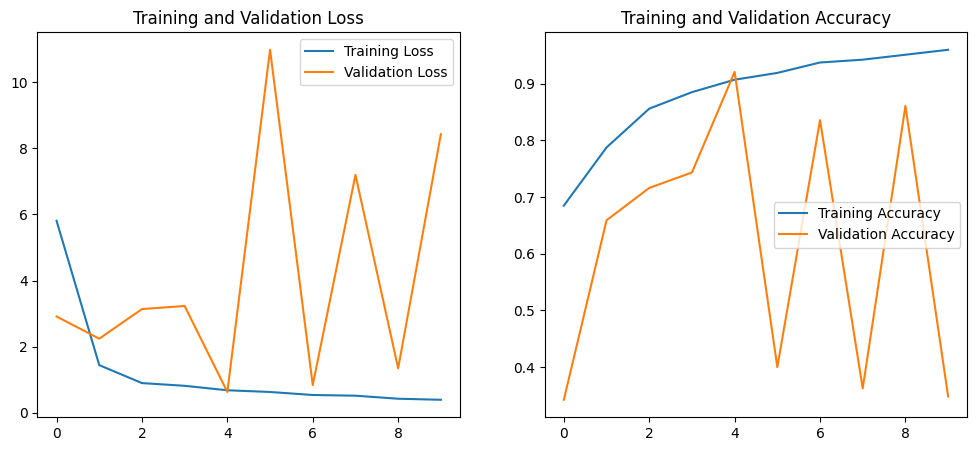

In [12]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [16]:
labels = np.concatenate([y for x, y in tf_dataset_test], axis=0)

# Predict and evaluate on the test set
test_predictions = model.predict(tf_dataset_test)
predicted_classes = np.round(test_predictions).astype('int32').flatten()

# Calculate Precision, Recall, and F1 Score
precision = precision_score(labels, predicted_classes)
recall = recall_score(labels, predicted_classes)
f1 = f1_score(labels, predicted_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


401/401 [==============================] - 115s 288ms/step
Precision: 0.6559633027522935
Recall: 0.39131469363474125
F1 Score: 0.49020046203144796


# Transfer Learning

## ResNet50

### pre-trained model and freeze layers

In [9]:
# from keras.preprocessing import image

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False

### custom layers

In [10]:
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
# 30% Dropout
x = Dropout(0.3)(x) 
# ReLU activation 
x = Dense(1024, activation='relu')(x)  
# Softmax for binary classification
predictions = Dense(1, activation='softmax')(x) 

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

### train the model

In [45]:
! SYSTEM_VERSION_COMPAT=0 pip install tensorflow-macos tensorflow-metal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.4/228.4 MB 16.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 40.8 MB/s eta 0:00:0000:0100:01
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: keras
    Found existing ins

In [11]:
from tensorflow.keras.optimizers import legacy

# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=legacy.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

steps_per_epoch = len(tf_dataset_train_augmented)
validation_steps = len(tf_dataset_val)

tf.config.run_functions_eagerly(True)
history = model.fit(
    tf_dataset_train_augmented,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=tf_dataset_val,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)
tf.config.run_functions_eagerly(False)

Epoch 1/20
5936/5936 [==============================] - 11291s 2s/step - loss: 0.1855 - accuracy: 0.5878 - val_loss: 1.0366 - val_accuracy: 0.3218
Epoch 2/20
5936/5936 [==============================] - 9656s 2s/step - loss: 0.0936 - accuracy: 0.5878 - val_loss: 1.1404 - val_accuracy: 0.3218
Epoch 3/20
5936/5936 [==============================] - 10530s 2s/step - loss: 0.0665 - accuracy: 0.5878 - val_loss: 1.3535 - val_accuracy: 0.3218
Epoch 4/20
5936/5936 [==============================] - 10427s 2s/step - loss: 0.0555 - accuracy: 0.5878 - val_loss: 2.5594 - val_accuracy: 0.3218
Epoch 5/20
5936/5936 [==============================] - 9036s 2s/step - loss: 0.0532 - accuracy: 0.5878 - val_loss: 1.6459 - val_accuracy: 0.3218
Epoch 6/20
5936/5936 [==============================] - 8913s 2s/step - loss: 0.0486 - accuracy: 0.5878 - val_loss: 2.9061 - val_accuracy: 0.3218
Epoch 7/20
5936/5936 [==============================] - 9069s 2s/step - loss: 0.0392 - accuracy: 0.5878 - val_loss: 1.400

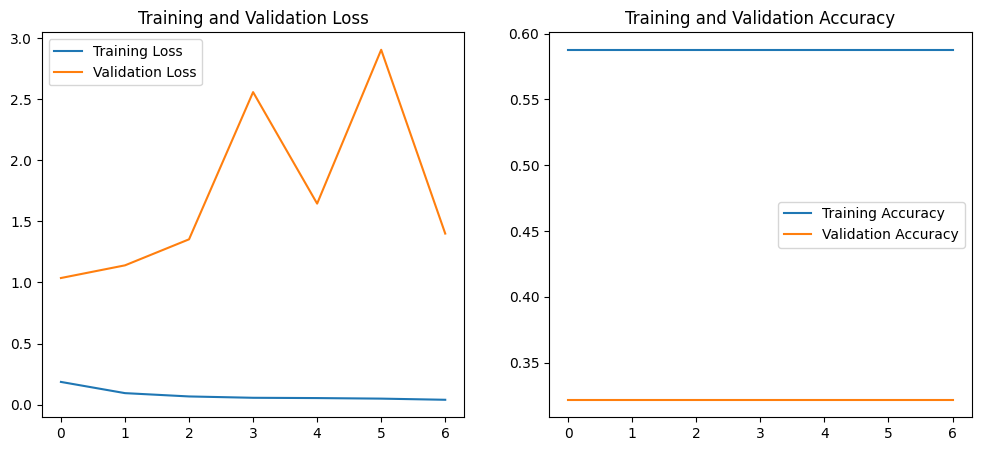

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [13]:

predictions = model.predict(tf_dataset_test)
predicted_classes = np.round(predictions).astype('int')
true_classes = np.concatenate([y for x, y in tf_dataset_test], axis=0)

precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


2565/2565 [==============================] - 757s 295ms/step
Precision: 0.6554628402089995
Recall: 1.0
F1 Score: 0.7918786508385152


## EfficientNetB0

In [48]:
from tensorflow.keras.applications import EfficientNetB0

# load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False

In [49]:
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)  # 30% Dropout
x = Dense(1024, activation='relu')(x)  # ReLU activation
predictions = Dense(1, activation='softmax')(x)  # Softmax layer

# create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [50]:
model.compile(optimizer=legacy.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


tf.config.run_functions_eagerly(True)
history = model.fit(
    tf_dataset_train_augmented,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=tf_dataset_val,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)
tf.config.run_functions_eagerly(False)

Epoch 1/20


371/371 [==============================] - 260s 700ms/step - loss: 0.5971 - accuracy: 0.5892 - val_loss: 0.2799 - val_accuracy: 0.3338
Epoch 2/20
371/371 [==============================] - 269s 724ms/step - loss: 0.3248 - accuracy: 0.5779 - val_loss: 0.3786 - val_accuracy: 0.3352
Epoch 3/20
371/371 [==============================] - 270s 728ms/step - loss: 0.2677 - accuracy: 0.5984 - val_loss: 0.3621 - val_accuracy: 0.3310
Epoch 4/20
371/371 [==============================] - 270s 727ms/step - loss: 0.2382 - accuracy: 0.5973 - val_loss: 0.5078 - val_accuracy: 0.3352
Epoch 5/20
371/371 [==============================] - 272s 733ms/step - loss: 0.1986 - accuracy: 0.5833 - val_loss: 0.3696 - val_accuracy: 0.3324
Epoch 6/20
371/371 [==============================] - 274s 738ms/step - loss: 0.2317 - accuracy: 0.5946 - val_loss: 0.3045 - val_accuracy: 0.3324
Epoch 7/20
371/371 [==============================] - 275s 741ms/step - loss: 0.2002 - accuracy: 0.5876 - val_loss: 0.2057 - val_accura

14:45:42 | WARNING | data_adapter    | Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 7420 batches). You may need to use the repeat() function when building your dataset.


371/371 [==============================] - 25s 68ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.5568 - val_accuracy: 0.3324


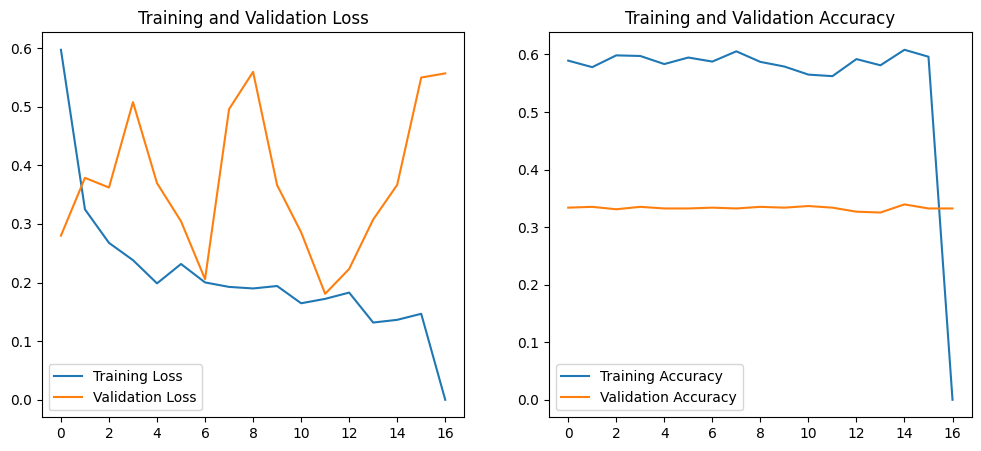

In [52]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [55]:
predictions = model.predict(tf_dataset_test)
predicted_classes = np.round(predictions).astype('int')
true_classes = np.concatenate([y for x, y in tf_dataset_test], axis=0)

precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



2565/2565 [==============================] - 557s 217ms/step
Precision: 0.6554628402089995
Recall: 1.0
F1 Score: 0.7918786508385152


## VGG16

In [61]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [62]:
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)  # 30% Dropout
x = Dense(1024, activation='relu')(x)  # ReLU activation
predictions = Dense(1, activation='softmax')(x)  # Softmax for binary classification

model = Model(inputs=base_model.input, outputs=predictions)

In [63]:
model.compile(optimizer=legacy.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


tf.config.run_functions_eagerly(True)
history = model.fit(
    tf_dataset_train_augmented,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=tf_dataset_val,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)
tf.config.run_functions_eagerly(False)

Epoch 1/20
371/371 [==============================] - 1622s 4s/step - loss: 0.4645 - accuracy: 0.5908 - val_loss: 0.8910 - val_accuracy: 0.3028
Epoch 2/20
371/371 [==============================] - 1768s 5s/step - loss: 0.3552 - accuracy: 0.5827 - val_loss: 0.4873 - val_accuracy: 0.2986
Epoch 3/20
371/371 [==============================] - 2084s 6s/step - loss: 0.3159 - accuracy: 0.5871 - val_loss: 0.8717 - val_accuracy: 0.2986
Epoch 4/20
371/371 [==============================] - 1834s 5s/step - loss: 0.2635 - accuracy: 0.5730 - val_loss: 0.5749 - val_accuracy: 0.3014
Epoch 5/20
371/371 [==============================] - 1800s 5s/step - loss: 0.2593 - accuracy: 0.5849 - val_loss: 0.4634 - val_accuracy: 0.3000
Epoch 6/20
371/371 [==============================] - 1591s 4s/step - loss: 0.2240 - accuracy: 0.6178 - val_loss: 0.5888 - val_accuracy: 0.3014
Epoch 7/20
371/371 [==============================] - 1869s 5s/step - loss: 0.2558 - accuracy: 0.5887 - val_loss: 0.7035 - val_accuracy:

23:38:14 | WARNING | data_adapter    | Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 7420 batches). You may need to use the repeat() function when building your dataset.


371/371 [==============================] - 198s 534ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.3862 - val_accuracy: 0.3085


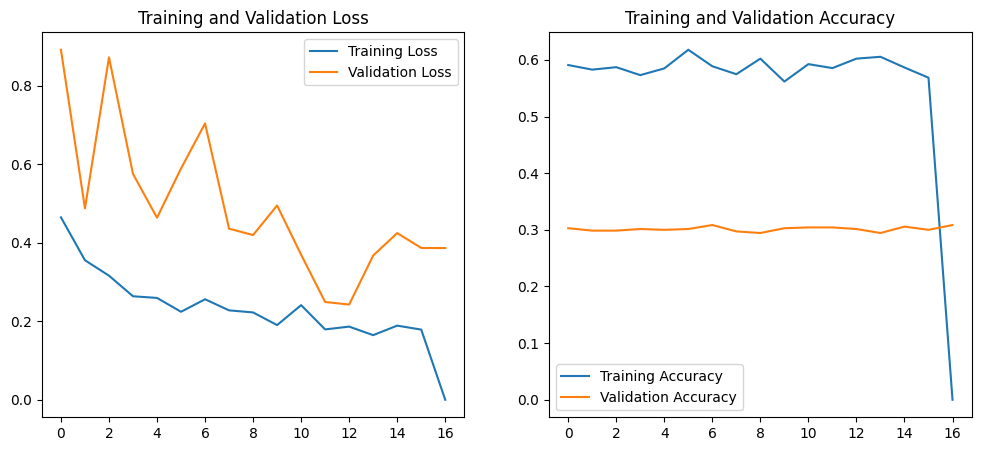

In [64]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [65]:
predictions = model.predict(tf_dataset_test)
predicted_classes = np.round(predictions).astype('int')
true_classes = np.concatenate([y for x, y in tf_dataset_test], axis=0)

precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

2565/2565 [==============================] - 3786s 1s/step
Precision: 0.6554628402089995
Recall: 1.0
F1 Score: 0.7918786508385152


##### CNN:
Precision: 0.6559633027522935

Recall: 0.39131469363474125

F1 Score: 0.49020046203144796


##### ResNet50:
Precision: 0.6554628402089995

Recall: 1.0

F1 Score: 0.7918786508385152


##### EfficientNetB0:
Precision: 0.6554628402089995

Recall: 1.0

F1 Score: 0.7918786508385152


##### VGG16:
Precision: 0.6554628402089995

Recall: 1.0

F1 Score: 0.7918786508385152

For precision, transfer learning models and the CNN model are the same. This indicates that the ability of each model to correctly identify the positive class is similar.

For recall, the CNN model has a significantly lower recall score compared to the transfer learning models and transfer learning models achieved perfect recall scores, which indicates that transfer learning models were able to identify all true positive cases in the daset.

Similarly, the transfer learning models have much higher f1 score, which means the transfer learning models are more balanced in terms of both precision and recall.


##### Explanation:
Pre-trained models such as transfer learning models often generalize better, especially when the amount of training data is limited. However, CNN model is more customized, leading to being outperformed by transfer learning model in recall and F1 score.

The architectures of transfer learning models (ResNet50, EfficientNetB0, and VGG16) are more sophisticated compared to a typical CNN + MLP model, which allows them to capture more nuanced patterns in the data, contributing to a better performance.